In [2]:
from crosspy.preprocessing.signal import filter_data
from crosspy.core.synchrony import wpli, cplv
from crosspy.core.criticality import dfa, compute_BiS, efi
import numpy as np
from numpy import log10
import matplotlib.pyplot as plt
from scipy.io import savemat
import os 


In [3]:
#filepath = '/data/sheng/MEG_source_data/case_0335/set1/parcel_ts/set1_parc2018yeo17_200_1000_weighted.npy'

filepath = '/data/sheng/ResearchMEG_SrcData/grr0026_set03_v202412.npy'
data = np.load(filepath) # data: channels x samples

################################################## Write out a matlab file?
SAVE_MAT = False
WRITE_DIR = '/mnt/megshare/Development/Sheng/__dump/__MAT_files/'
if SAVE_MAT == True: 
    
    OFFSET = 33
    SUBJ = filepath[OFFSET:OFFSET+4]
    SET  = os.path.basename(filepath)[0:4]
    if filepath[OFFSET+4] == '/':
        SUBJ = SUBJ + '_1'
    else:
        SUBJ = SUBJ + '_' + filepath[OFFSET+5]

    parcTS = {'parcTS': data}
    matfile = WRITE_DIR + 'ver_2024123_' + SUBJ + '_' + SET + '.mat'
    savemat(matfile, parcTS)

In [4]:
data.shape

(200, 603000)

In [5]:
def process_data(data, sfreq, n_freqs):
    #data = np.load('test.npy') # channels x samples
    NORM_POWER   = True
    n_chans      = data.shape[0]    
    omega        = 7.5
    MIN_FREQ     = 1     # Hz
    MAX_FREQ     = 225   # Hz
    #n_freqs      = 20
    DFA_MIN_WIN  = 20 # num x [f narrow-band cycle length]
    DFA_MAX_WIN  = 10 # e.g., 5 means 1/5 of the recording duration
    FEI_WIN_MULTIP   = 50
    
    frequencies        = np.round(np.geomspace(MIN_FREQ, MAX_FREQ, n_freqs), 2)
    wpli_freqwise      = np.zeros((n_freqs, n_chans, n_chans))
    cplv_freqwise      = np.zeros((n_freqs, n_chans, n_chans), dtype=complex)
    dfa_freqwise       = np.zeros((n_freqs, n_chans))
    fei_freqwise       = np.zeros((n_freqs, n_chans))
    bis_freqwise       = np.zeros((n_freqs, n_chans))
    
    for freq_idx, freq in enumerate(frequencies):
        print(str(freq_idx) + ': ' + str(freq) + ' Hz ...')
        dfa_window_sizes = np.geomspace(DFA_MIN_WIN*sfreq/freq, data.shape[-1]//DFA_MAX_WIN, 30).astype(int)
        fei_window_size = int(FEI_WIN_MULTIP*sfreq/freq)
        
        data_filt = filter_data(data, sfreq=sfreq, frequency=freq, omega=omega, n_jobs='cuda')
        data_envelope = np.abs(data_filt)
        
        data_power = data_envelope**2
        if NORM_POWER: 

            CNETERED = data_power - np.median(data_power)
            data_power = CNETERED / np.max(np.abs(CNETERED))
            

        # have to use get() function to move data from GPU to CPU
        wpli_freqwise[freq_idx] = wpli(data_filt).get()
        cplv_freqwise[freq_idx] = cplv(data_filt).get()
        dfa_freqwise[freq_idx] = dfa(data_envelope, window_lengths = dfa_window_sizes)[2]
        fei_freqwise[freq_idx] = efi(data_envelope, window_size=fei_window_size, overlap=0.5).get()  
        
        #bis_freqwise[freq_idx] = compute_BiS(data_power.get(), method='mle')   #need to move GPU to CPU   

    
    return frequencies, wpli_freqwise, cplv_freqwise, dfa_freqwise, fei_freqwise, bis_freqwise

In [6]:
# TEST RUN
freq_bank, wPLI, cPLV, DFA, fEI, BiS = process_data(data, sfreq=1000, n_freqs=50)

SAVE_RESULTS = True
WRITE_DIR = '/mnt/megshare/Development/Sheng/__dump/__COMPUTATION_RESULTS/'
if SAVE_RESULTS == True: 
    
    OFFSET = 33
    SUBJ = filepath[OFFSET:OFFSET+4]
    SET  = os.path.basename(filepath)[0:4]
    if filepath[OFFSET+4] == '/':
        SUBJ = SUBJ + '_1'
    else:
        SUBJ = SUBJ + '_' + filepath[OFFSET+5]

    parcTS = {'parcTS': data}
    matfile = WRITE_DIR + '2024123_RESULTS_' + SUBJ + '_' + SET + '.mat'
    savemat(matfile, {'wPLI': wPLI, 'cPLV': cPLV, 'DFA': DFA, 'fEI':fEI, 'BiS': BiS, 'freq_bank':freq_bank})

0: 1.0 Hz ...


/home/sheng/anaconda3/envs/mne/lib/python3.12/site-packages/cupy/linalg/_solve.py:171: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  warnings.warn(


1: 1.12 Hz ...
2: 1.25 Hz ...
3: 1.39 Hz ...
4: 1.56 Hz ...
5: 1.74 Hz ...
6: 1.94 Hz ...
7: 2.17 Hz ...
8: 2.42 Hz ...
9: 2.7 Hz ...
10: 3.02 Hz ...
11: 3.37 Hz ...
12: 3.77 Hz ...
13: 4.21 Hz ...
14: 4.7 Hz ...
15: 5.25 Hz ...
16: 5.86 Hz ...
17: 6.55 Hz ...
18: 7.31 Hz ...
19: 8.17 Hz ...
20: 9.12 Hz ...
21: 10.19 Hz ...
22: 11.38 Hz ...
23: 12.71 Hz ...
24: 14.19 Hz ...
25: 15.85 Hz ...
26: 17.71 Hz ...
27: 19.77 Hz ...
28: 22.09 Hz ...
29: 24.67 Hz ...
30: 27.55 Hz ...
31: 30.77 Hz ...
32: 34.37 Hz ...
33: 38.38 Hz ...
34: 42.87 Hz ...
35: 47.88 Hz ...
36: 53.47 Hz ...
37: 59.72 Hz ...
38: 66.7 Hz ...
39: 74.5 Hz ...
40: 83.2 Hz ...
41: 92.93 Hz ...
42: 103.79 Hz ...
43: 115.92 Hz ...
44: 129.47 Hz ...
45: 144.6 Hz ...
46: 161.5 Hz ...
47: 180.37 Hz ...
48: 201.46 Hz ...
49: 225.0 Hz ...


Text(0.5, 0, 'Freq (Hz)')

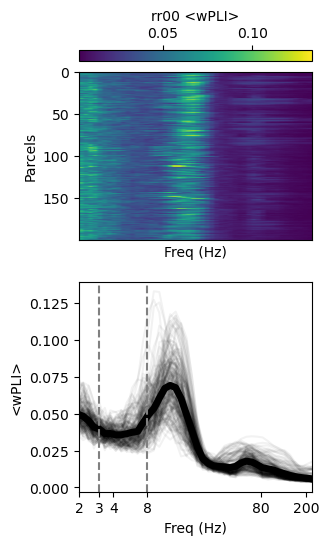

In [6]:
########################################################
#######                                   PLV 
########################################################
whatData =2    # 1: PLV, 0: iPLV; 2: wPLI

VECT = np.zeros((200, freq_bank.size))

if whatData ==1: # PLV
    toShow = abs(cPLV)
    ttlPLV = 'PLV'
elif whatData ==0: #iPLV
    toShow = abs(cPLV.imag)
    ttlPLV = 'iPLV'
elif whatData ==2: #wPLI
    toShow = abs(wPLI)
    ttlPLV = 'wPLI'
else:
    toShow2 = abs(cPLV.real)
    ttlPLV = 'real PLV'
    

for i in range(freq_bank.size):
    #print(f)
    VECT[:, i] = np.mean(toShow[i, :, :], axis=0)

########################################################
# plot
########################################################
fig, axes = plt.subplots(2, 1, figsize=(3, 6))
plt.cla()

PEAK1 = 3  # Hz
PEAK2 = 8
#PEAK3 = 40

im2 = axes[0].imshow(VECT, aspect='auto')
axes[0].set_xlabel('Freq (Hz)')
axes[0].set_ylabel('Parcels')
axes[0].set_xticks([])
#axes[0].set_xticks([0, 13, 31])
#axes[0].set_xticklabels([freq_bank[0], freq_bank[13],  freq_bank[31]])
cbar = plt.colorbar(im2, ax=axes[0], location='top')
cbar.set_label(filepath[33:37] + ' <' + ttlPLV + '>')

im1 = axes[1].plot(np.log10(freq_bank), VECT.T, color='black', alpha=0.05)
im1 = axes[1].plot(np.log10(freq_bank), np.mean(VECT, axis=0), linewidth=5, color='black', alpha=1)
im1 = axes[1].axvline(x=log10(PEAK1), color='gray', linestyle='--')
im1 = axes[1].axvline(x=log10(PEAK2), color='gray', linestyle='--')
#im1 = axes[1].axvline(x=log10(PEAK3), color='gray', linestyle='--')
axes[1].set_xticks([log10(2), log10(4), log10(PEAK1), log10(PEAK2), log10(80), log10(200)])
axes[1].set_xticklabels(['2', '4', str(PEAK1), str(PEAK2), '80', '200'])
#axes[1].set_title('synch')
axes[1].set_xlim(log10(2), log10(225))
axes[1].set_ylabel('<' + ttlPLV + '>')
axes[1].set_xlabel('Freq (Hz)')

(Text(0.5, 0, 'Freq (Hz)'), Text(0, 0.5, 'DFA'))

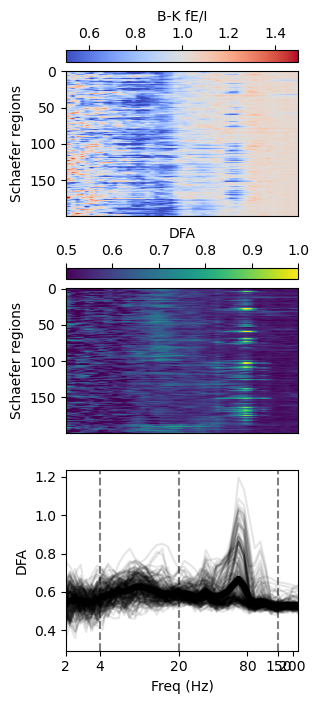

In [7]:
########################################################
##                               dfa, fE/I, BiS etc.
########################################################
toShow1 = DFA.T
toShow2 = fEI.T
toShow3 = BiS.T
#toShow3 = DFA.T

##############################################
fig, axes = plt.subplots(3, 1, figsize=(3, 8))


############################################## fE/I
im1 = axes[0].imshow(toShow2, aspect='auto', cmap='coolwarm', vmin=0.5, vmax=1.5)
axes[0].set_ylabel('Schaefer regions')
axes[0].set_xticks([]) 
#axes[0].set_title('B-L fE/I index')
#axes[0].set_xlabel('Freq sequencies (Hz)')
#axes[0].set_xticks([0, 8, 13,31, 38])
#axes[0].set_xticklabels([freq_bank[0], freq_bank[8],  freq_bank[13],  freq_bank[31],  freq_bank[38]])
cbar1 = plt.colorbar(im1, ax=axes[0], location='top')
cbar1.set_label('B-K fE/I')

##############################################
im2 = axes[1].imshow(toShow1, aspect='auto', vmin=0.5, vmax=1)
axes[1].set_ylabel('Schaefer regions')
#axes[1].set_title('DFA'),  
#axes[1].set_xlabel('Freq sequencies (Hz)')
#axes[1].set_xticks([0, 15, 38])  #axes[2].set_xticks([0, 15, 31, 38])
#axes[1].set_xticklabels([freq_bank[0],freq_bank[15], freq_bank[38]])
axes[1].set_xticks([]) 
cbar2 = plt.colorbar(im2, ax=axes[1], location='top')
cbar2.set_label('DFA')

##############################################

PEAK1 = 4
PEAK2 = 20
PEAK3 = 150
im3 = axes[2].axvline(x=log10(PEAK1), color='gray', linestyle='--')
im3 = axes[2].axvline(x=log10(PEAK2), color='gray', linestyle='--')
im3 = axes[2].axvline(x=log10(PEAK3), color='gray', linestyle='--')
im3 = axes[2].plot(np.log10(freq_bank), DFA, color='black', alpha=0.1)
im3 = axes[2].plot(np.log10(freq_bank), 
                   np.mean(DFA, axis=1), 
                   linewidth=5, color='black', alpha=1)
axes[2].set_xticks([log10(2), log10(PEAK1), log10(PEAK2), log10(PEAK3), log10(80), log10(200)])
axes[2].set_xticklabels(['2', str(PEAK1), str(PEAK2), str(PEAK3), '80', '200'])
#axes[2].set_title('DFA')
axes[2].set_xlim(log10(2), log10(225))
axes[2].set_xlabel('Freq (Hz)'), axes[2].set_ylabel('DFA')



In [8]:
VECT.shape

(200, 50)

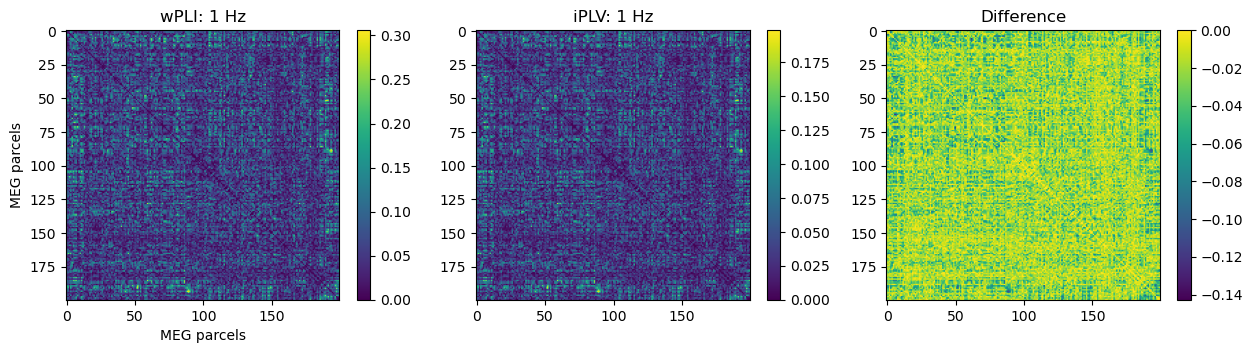

In [28]:
i =0
PLV = 0    # 1: PLV, 0: iPLV; 2: real plv

toShow1 = abs(wPLI[i])
if PLV ==1:
    toShow2 = abs(cPLV[i])
    ttlPLV = 'PLV'
elif PLV ==0:
    toShow2 = abs(cPLV[i].imag)
    ttlPLV = 'iPLV'
else:
    toShow2 = abs(cPLV[i].real)
    ttlPLV = 'real PLV'


np.fill_diagonal(toShow1, 0), np.fill_diagonal(toShow2, 0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))

im1 = axes[0].imshow(toShow1, aspect='auto')
axes[0].set_title('wPLI: '+ str(np.ceil(freq_bank[i]).astype(int)) + ' Hz')
axes[0].set_xlabel('MEG parcels'), axes[0].set_ylabel('MEG parcels')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(toShow2, aspect='auto')

axes[1].set_title(ttlPLV+ ': '+ str(np.ceil(freq_bank[i]).astype(int)) + ' Hz')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(toShow2-toShow1, aspect='auto')
axes[2].set_title('Difference')
plt.colorbar(im3, ax=axes[2])

In [10]:
from crosspy.postprocessing.visualization.vis_3d import BrainSurface
from crosspy.postprocessing.visualization.utils import draw_four_views
fsaverage_path = r'/usr/local/freesurfer/subjects/fsaverage' # path to a parcellation, required for labels, anatomy and so on
# create to hemis separately, choose parcellation that match your data and any surface that you want, e.g. pial/inflated
brain_surf_lh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_200Parcels_17Networks_order', 
                             hemis=['lh'], surface='inflated')
brain_surf_rh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_200Parcels_17Networks_order', 
                             hemis=['rh'], surface='inflated')
brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]
# should be your data parcel names! 
surf_parcel_names = np.array(brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]) 
idx_sorted = np.argsort(surf_parcel_names) 
surf_parcel_names = surf_parcel_names[idx_sorted] 

1.25  Hz


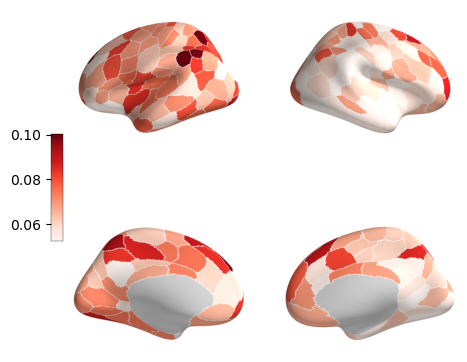

In [29]:
# this is your data, should be 1D array of the same size as your parcellation
# freq index
IDX = 2
#VECT=wPLI

toShow = 0 # {-1: parcID; 0: wPLI; 1: fEI; 2: DFA; }

if toShow==0: ## iPLV
    values = VECT[:, IDX]
    CMAP='Reds'
    Z_LIM=np.percentile(values, (10,99))
elif toShow == 1: # fEI
    values = fEI[IDX, :]
    CMAP = 'coolwarm'
    Z_LIM = [0.8, 1.2]
elif toShow == 2: # dfa
    values = DFA[IDX, :]
    CMAP = 'viridis'
    #Z_LIM = [0.5, 0.7]
    Z_LIM=np.percentile(values, (1,95))
elif toShow == -1: # brain regions    
    values = np.array(range(200))
    CMAP = 'coolwarm'
    Z_LIM = [0, 200]
    

# axes should be a 2x2 numpy array
fig, axes = plt.subplots(figsize=(5,5), ncols=2, nrows=2)

# the actual plotting function. 
draw_four_views(axes, values, surf_parcel_names, brain_3d_surfaces, cmap=CMAP, norm_values=Z_LIM)
print(freq_bank[IDX], ' Hz')


In [12]:
freq_bank[IDX]

1.0

In [38]:
wPLI.shape

(50, 200, 200)

8.17 Hz


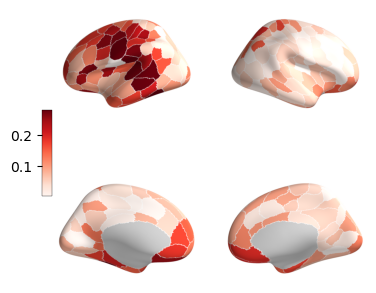

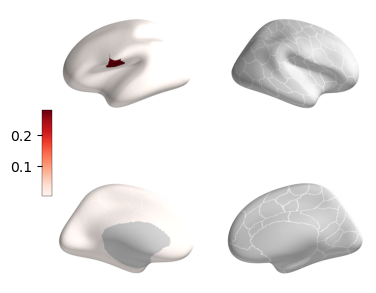

In [37]:
# seed based connectivity plotting
#toShow = abs(cPLV.imag)
toShow = abs(wPLI)
FREQ_ID = 19
PARC_ID = 84
values = toShow[FREQ_ID, PARC_ID,: ]
Z_LIM=np.percentile(values, (1,99))
CMAP = 'Reds'

# axes should be a 2x2 numpy array
fig, axes = plt.subplots(figsize=(4,4), ncols=2, nrows=2)
# the actual plotting function. 
draw_four_views(axes, values, surf_parcel_names, brain_3d_surfaces, cmap=CMAP, norm_values=Z_LIM)



# Point to the parcel
values = np.zeros(100)
values[PARC_ID] = 1

# axes should be a 2x2 numpy array
fig, axes = plt.subplots(figsize=(4,4), ncols=2, nrows=2)
# the actual plotting function. 
draw_four_views(axes, values, surf_parcel_names, brain_3d_surfaces, cmap=CMAP, norm_values=Z_LIM)
print(freq_bank[FREQ_ID], 'Hz')

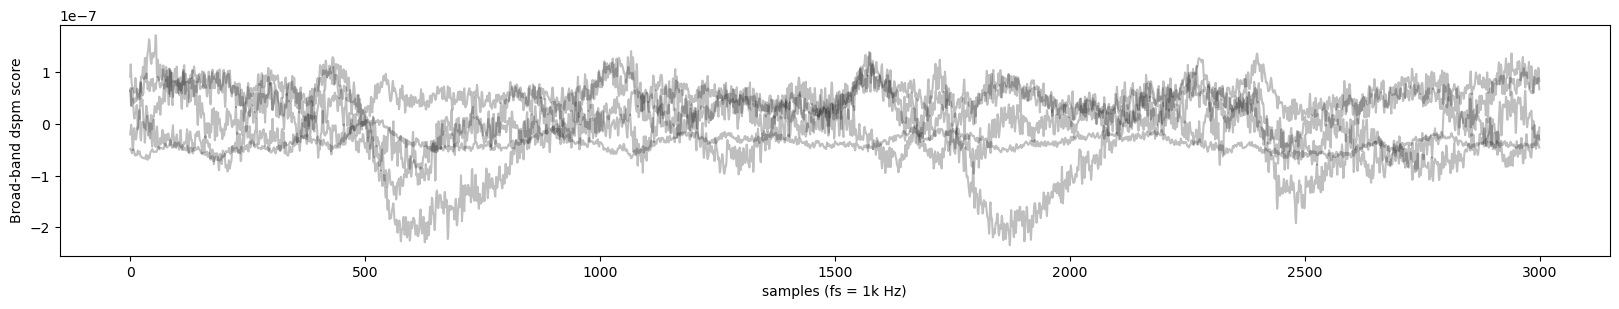

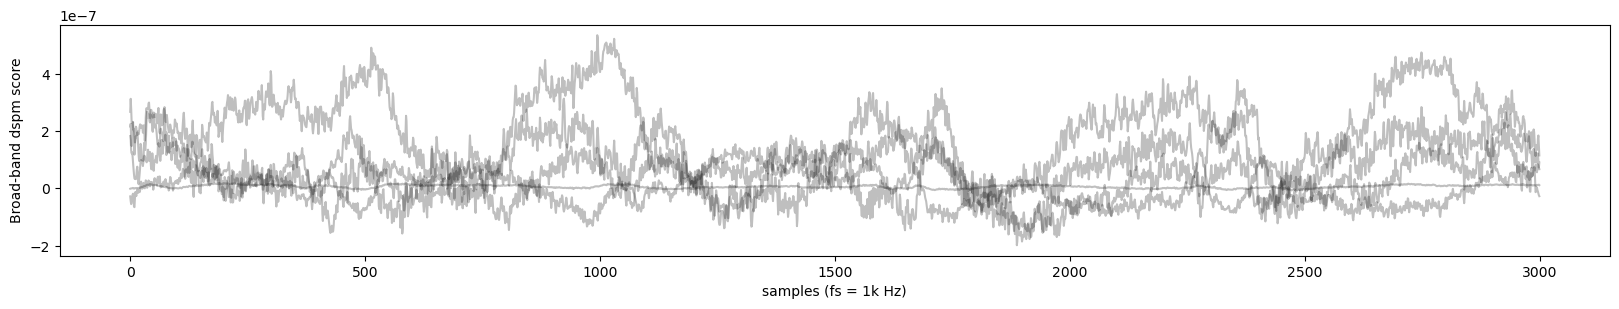

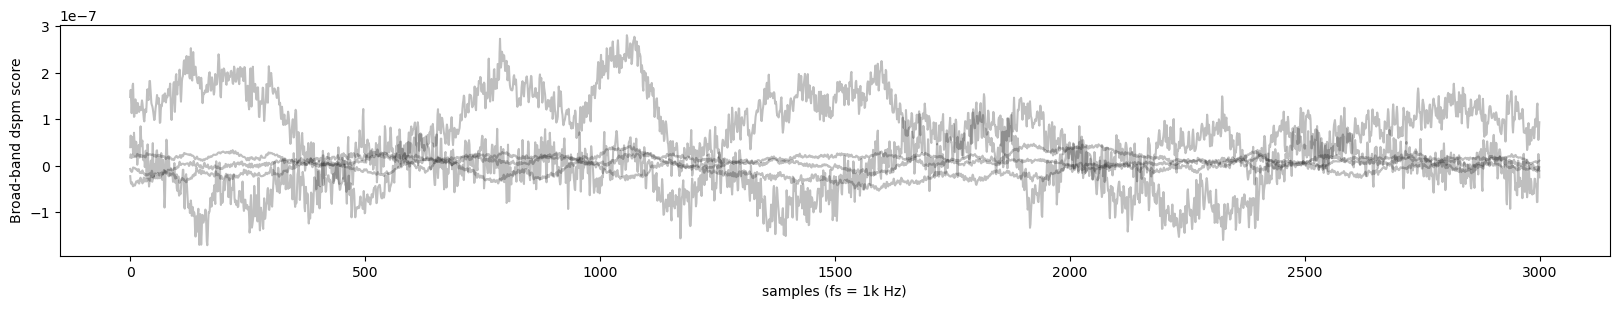

In [69]:
# show traces if need be###################################################################

OFFSET = 72000
DURATION = 3000

plt.figure(figsize=(20,3))
toShow1 = data[10:15, OFFSET:OFFSET+DURATION].T  # show some broadband
plt.plot(toShow1, color='black', alpha=0.25)
plt.xlabel('samples (fs = 1k Hz)')
plt.ylabel('Broad-band dspm score')
plt.show()

plt.figure(figsize=(20,3))
toShow1 = data[80:85, OFFSET:OFFSET+DURATION].T  # show some broadband
plt.plot(toShow1, color='black', alpha=0.25)
plt.xlabel('samples (fs = 1k Hz)')
plt.ylabel('Broad-band dspm score')
plt.show()

plt.figure(figsize=(20,3))
toShow1 = data[150:155, OFFSET:OFFSET+DURATION].T  # show some broadband
plt.plot(toShow1, color='black', alpha=0.25)
plt.xlabel('samples (fs = 1k Hz)')
plt.ylabel('Broad-band dspm score')
plt.show()

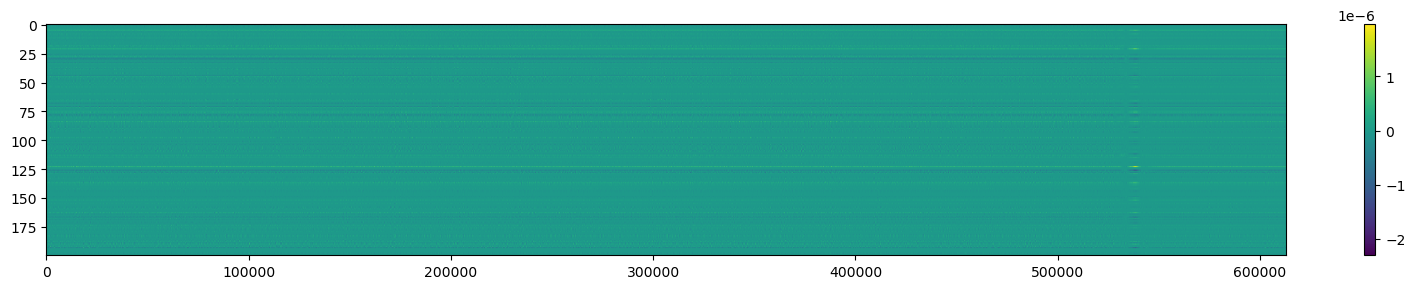

In [70]:
OFFSET = 60000
DURATION = 60000

plt.figure(figsize=(20,3))
#plt.imshow(data[:, OFFSET:OFFSET+DURATION], aspect='auto')
plt.imshow(data, aspect='auto')
plt.colorbar()
plt.show()